In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.miscmodels.ordinal_model import OrderedModel
from mord import LogisticIT
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import StackingClassifier
import pickle
from sklearn.model_selection import learning_curve
from sklearn.ensemble import StackingClassifier

In [2]:
df = pd.read_csv('taxi_data_final.csv')

In [3]:
df.head()

,LocationID,day,month,year,hour,passenger_count,busyness_rank
0,4,0,1,2022,0,91.0,4
1,4,0,1,2022,1,35.0,5
2,4,0,1,2022,2,13.0,5
3,4,0,1,2022,3,9.0,5
4,4,0,1,2022,4,10.0,5


In [4]:
df.drop(columns=['passenger_count'], inplace=True)

**Convert data types**

In [5]:
df.dtypes

LocationID       int64
day              int64
month            int64
year             int64
hour             int64
busyness_rank    int64
dtype: object

In [6]:
df['LocationID'] = df['LocationID'].astype('category')
df['month'] = df['month'].astype('category')
df['day'] = df['day'].astype('category')
df['hour'] = df['hour'].astype('category')
df['year'] = df['year'].astype('category')

features = ['LocationID', 'month', 'day', 'hour', 'year']

In [7]:
df.to_csv('taxi_data.csv', index=False)

**Split data using a 30% test 70% train split**

In [8]:
X = df.drop(columns=['busyness_rank'])
y = df['busyness_rank']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

**Balanced Ranks**

In [9]:
def balance_dataset(X, y):
    df_balanced = pd.concat([X, y], axis=1)
    min_size = df_balanced['busyness_rank'].value_counts().min()
    df_balanced = df_balanced.groupby('busyness_rank', group_keys=False).apply(lambda x: x.sample(min_size)).reset_index(drop=True)
    X_balanced = df_balanced.drop(columns=['busyness_rank'])
    y_balanced = df_balanced['busyness_rank']
    return X_balanced, y_balanced

X_balanced, y_balanced = balance_dataset(X, y)

X_train_balanced, X_test_balanced, y_train_balanced, y_test_balanced = train_test_split(X_balanced, y_balanced, test_size=0.3, random_state=42, stratify=y_balanced)

/var/folders/8v/myv9ql5d1lg4ct7vbb0zh8000000gn/T/ipykernel_9052/2023984877.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_balanced = df_balanced.groupby('busyness_rank', group_keys=False).apply(lambda x: x.sample(min_size)).reset_index(drop=True)


In [10]:
print("Training set class distribution:")
print(y_train.value_counts(normalize=True))

print("\nTesting set class distribution:")
print(y_test.value_counts(normalize=True))

print("Training set class distribution with balancing:")
print(y_train_balanced.value_counts(normalize=True))

print("\nTesting set class distribution with balancing:")
print(y_test_balanced.value_counts(normalize=True))

Training set class distribution:
busyness_rank
5    0.200925
1    0.200187
3    0.199854
2    0.199708
4    0.199327
Name: proportion, dtype: float64

Testing set class distribution:
busyness_rank
5    0.202390
2    0.201044
3    0.199437
1    0.198992
4    0.198137
Name: proportion, dtype: float64
Training set class distribution with balancing:
busyness_rank
4    0.2
3    0.2
5    0.2
1    0.2
2    0.2
Name: proportion, dtype: float64

Testing set class distribution with balancing:
busyness_rank
2    0.2
5    0.2
4    0.2
3    0.2
1    0.2
Name: proportion, dtype: float64


**Encoded Data**

In [11]:
df_encoded = pd.get_dummies(df, columns=['LocationID', 'day', 'month', 'year', 'hour'], drop_first=True)

X_encoded = df_encoded.drop(columns=['busyness_rank'])
y_encoded = df_encoded['busyness_rank']

X_train_encoded, X_test_encoded, y_train_encoded, y_test_encoded = train_test_split(X_encoded, y_encoded, test_size=0.3, random_state=42)

**Weighted Data**

In [12]:
df_weighted = df

for i in range(5):
    df_weighted[f'LocationID_dup_{i}'] = df_weighted['LocationID']

In [13]:
X_weighted = df_weighted.drop(columns=['busyness_rank'])
y_weighted = df_weighted['busyness_rank']

X_train_weighted, X_test_weighted, y_train_weighted, y_test_weighted = train_test_split(X_weighted, y_weighted, test_size=0.3, random_state=42)

**Define ranks for displaying metrics**

In [14]:
ranks = ['1 (busiest)', '2', '3', '4', '5 (quietest)']

**Evaluation Function**

In [15]:
def evaluate_model(y_test, y_pred):
    """
    Evaluates a classification model and prints key metrics.
    
    Parameters:
    y_test (array-like): True labels
    y_pred (array-like): Predicted labels
    """
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=ranks)
    
    fig, ax = plt.subplots(figsize=(8, 5))
    disp.plot(cmap='Blues', ax=ax, values_format='d')
    
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.title('Confusion Matrix')
    plt.show()
    
    class_report = classification_report(y_test, y_pred, output_dict=True)
    class_report_df = pd.DataFrame(class_report).transpose()

    print("\nClassification Report:")
    print(class_report_df)

# 1. Logistic Regression
### Original Data  

In [16]:
logreg = LogisticRegression(max_iter=5000)
logreg.fit(X_train, y_train)

LogisticRegression(max_iter=5000)

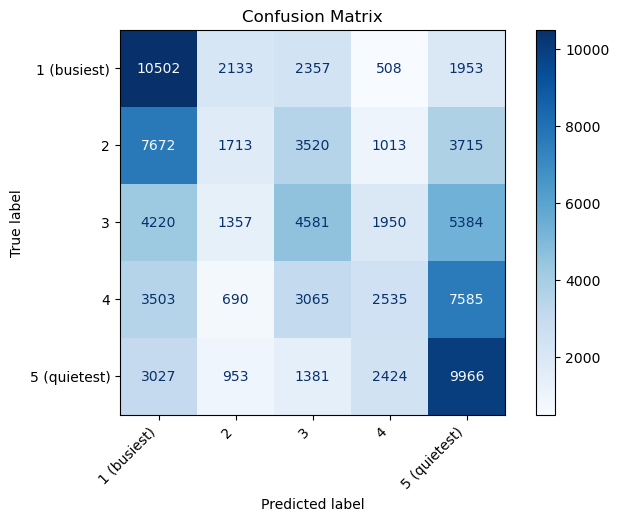


Classification Report:
              precision    recall  f1-score       support
1              0.363089  0.601730  0.452897  17453.000000
2              0.250219  0.097147  0.139957  17633.000000
3              0.307367  0.261891  0.282813  17492.000000
4              0.300712  0.145874  0.196451  17378.000000
5              0.348425  0.561433  0.429995  17751.000000
accuracy       0.334033  0.334033  0.334033      0.334033
macro avg      0.313962  0.333615  0.300422  87707.000000
weighted avg   0.313957  0.334033  0.300614  87707.000000


In [17]:
y_pred_logreg = logreg.predict(X_test)

evaluate_model(y_test, y_pred_logreg)

### Balanced Data

In [18]:
logreg.fit(X_train_balanced, y_train_balanced)

LogisticRegression(max_iter=5000)

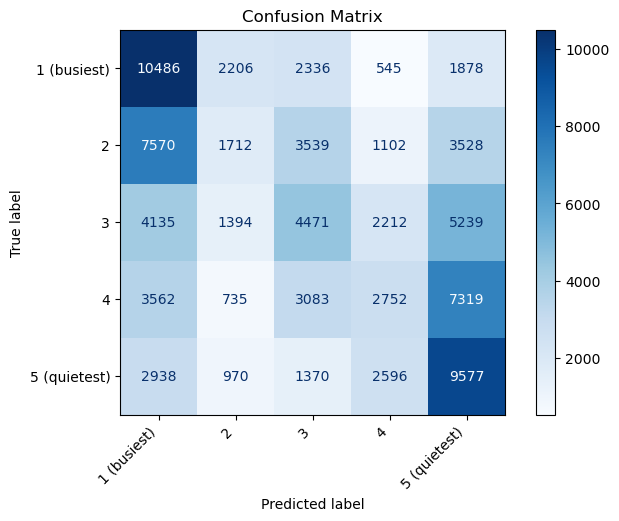


Classification Report:
              precision    recall  f1-score       support
1              0.365480  0.600882  0.454510  17451.000000
2              0.243979  0.098103  0.139938  17451.000000
3              0.302115  0.256203  0.277271  17451.000000
4              0.298903  0.157699  0.206467  17451.000000
5              0.347736  0.548794  0.425720  17451.000000
accuracy       0.332336  0.332336  0.332336      0.332336
macro avg      0.311643  0.332336  0.300781  87255.000000
weighted avg   0.311643  0.332336  0.300781  87255.000000


In [19]:
y_balanced_pred_logreg = logreg.predict(X_test_balanced)

evaluate_model(y_test_balanced, y_balanced_pred_logreg)

### Encoded Data

In [20]:
logreg.fit(X_train_encoded, y_train_encoded)

LogisticRegression(max_iter=5000)

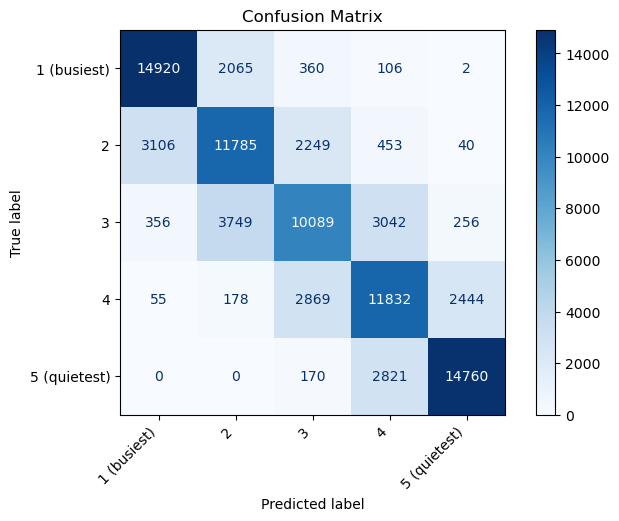


Classification Report:
              precision    recall  f1-score       support
1              0.809242  0.854867  0.831429  17453.000000
2              0.662935  0.668349  0.665631  17633.000000
3              0.641101  0.576778  0.607241  17492.000000
4              0.648187  0.680861  0.664122  17378.000000
5              0.843332  0.831502  0.837376  17751.000000
accuracy       0.722702  0.722702  0.722702      0.722702
macro avg      0.720959  0.722472  0.721160  87707.000000
weighted avg   0.721283  0.722702  0.721439  87707.000000


In [21]:
y_encoded_pred_logreg = logreg.predict(X_test_encoded)

evaluate_model(y_test_encoded, y_encoded_pred_logreg)

### Weighted Data

In [22]:
logreg.fit(X_train_weighted, y_train_weighted)

LogisticRegression(max_iter=5000)

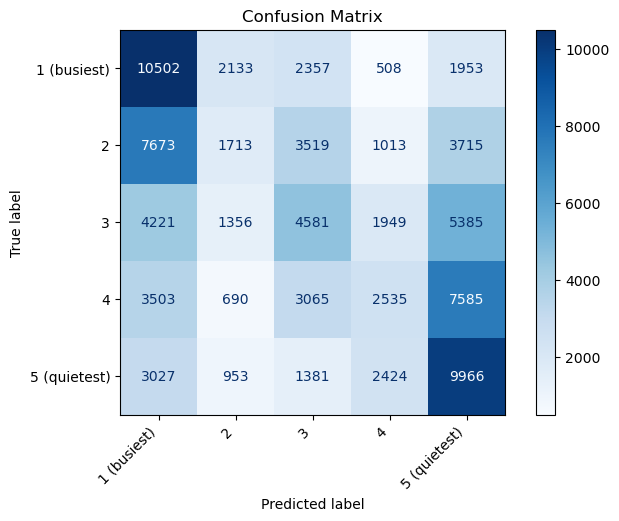


Classification Report:
              precision    recall  f1-score       support
1              0.363064  0.601730  0.452877  17453.000000
2              0.250256  0.097147  0.139962  17633.000000
3              0.307388  0.261891  0.282821  17492.000000
4              0.300747  0.145874  0.196458  17378.000000
5              0.348413  0.561433  0.429986  17751.000000
accuracy       0.334033  0.334033  0.334033      0.334033
macro avg      0.313974  0.333615  0.300421  87707.000000
weighted avg   0.313968  0.334033  0.300613  87707.000000


In [23]:
y_weighted_pred_logreg = logreg.predict(X_test_weighted)

evaluate_model(y_test_weighted, y_weighted_pred_logreg)

# 2. Ordinal Logistic Regression
### Original Data

In [24]:
ordinal_model = LogisticIT()
ordinal_model.fit(X_train, y_train)

LogisticIT()

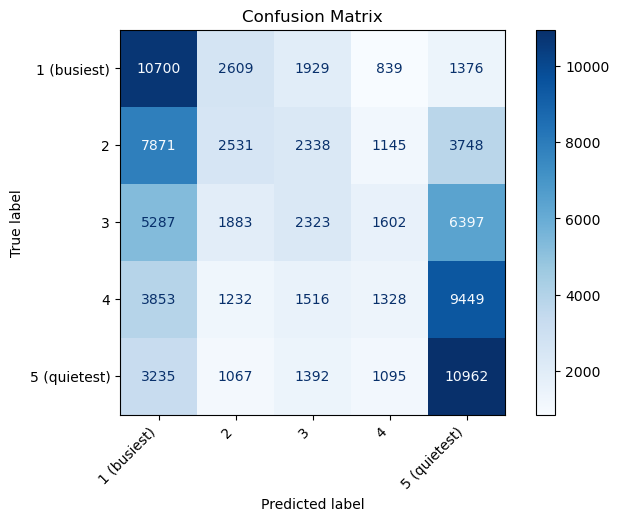


Classification Report:
              precision    recall  f1-score       support
1              0.345764  0.613075  0.442158  17453.000000
2              0.271508  0.143538  0.187794  17633.000000
3              0.244578  0.132804  0.172138  17492.000000
4              0.221002  0.076418  0.113567  17378.000000
5              0.343292  0.617543  0.441278  17751.000000
accuracy       0.317466  0.317466  0.317466      0.317466
macro avg      0.285229  0.316676  0.271387  87707.000000
weighted avg   0.285435  0.317466  0.271884  87707.000000


In [25]:
y_pred_ordinal = ordinal_model.predict(X_test)

evaluate_model(y_test, y_pred_ordinal)

### Balanced Data

In [26]:
ordinal_model.fit(X_train_balanced, y_train_balanced)

LogisticIT()

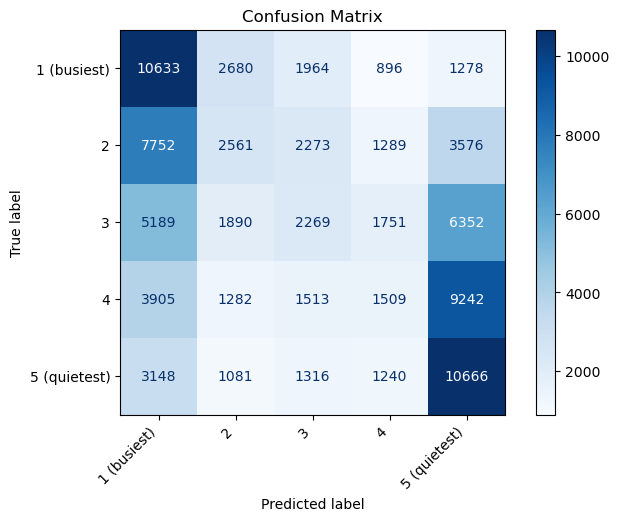


Classification Report:
              precision    recall  f1-score      support
1              0.347177  0.609306  0.442323  17451.00000
2              0.269749  0.146754  0.190091  17451.00000
3              0.243064  0.130021  0.169417  17451.00000
4              0.225729  0.086471  0.125041  17451.00000
5              0.342804  0.611197  0.439246  17451.00000
accuracy       0.316750  0.316750  0.316750      0.31675
macro avg      0.285705  0.316750  0.273224  87255.00000
weighted avg   0.285705  0.316750  0.273224  87255.00000


In [27]:
y_balanced_pred_ordinal = ordinal_model.predict(X_test_balanced)

evaluate_model(y_test_balanced, y_balanced_pred_ordinal)

### Encoded Data

In [28]:
ordinal_model.fit(X_train_encoded, y_train_encoded)

LogisticIT()

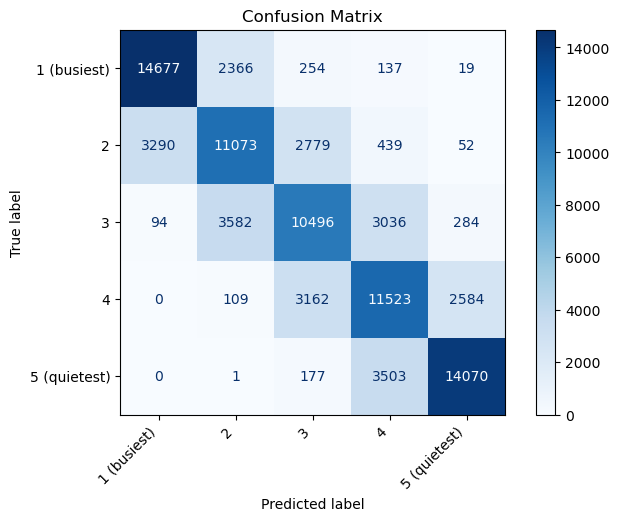


Classification Report:
              precision    recall  f1-score       support
1              0.812635  0.840944  0.826547  17453.000000
2              0.646372  0.627970  0.637038  17633.000000
3              0.622243  0.600046  0.610943  17492.000000
4              0.618253  0.663080  0.639882  17378.000000
5              0.827209  0.792631  0.809551  17751.000000
accuracy       0.705063  0.705063  0.705063      0.705063
macro avg      0.705342  0.704934  0.704792  87707.000000
weighted avg   0.705673  0.705063  0.705023  87707.000000


In [29]:
y_encoded_pred_ordinal = ordinal_model.predict(X_test_encoded)

evaluate_model(y_test_encoded, y_encoded_pred_ordinal)

# 3. Random Forest
### Original Data

In [30]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [31]:
y_pred_rf = rf.predict(X_test)

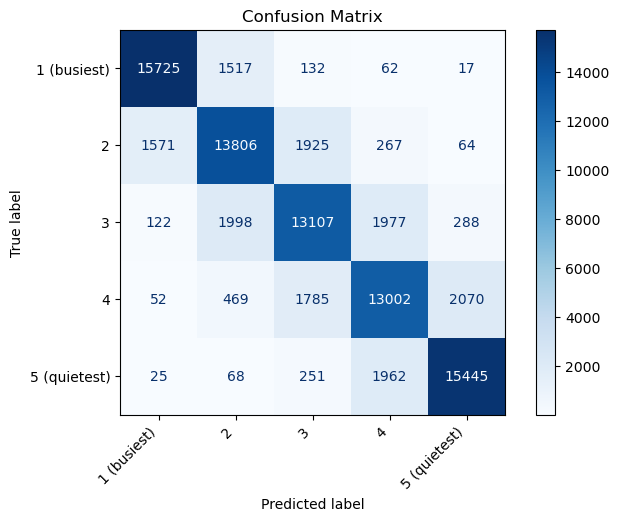


Classification Report:
              precision    recall  f1-score       support
1              0.898828  0.900991  0.899908  17453.000000
2              0.773099  0.782964  0.778000  17633.000000
3              0.762035  0.749314  0.755621  17492.000000
4              0.752866  0.748187  0.750520  17378.000000
5              0.863621  0.870092  0.866844  17751.000000
accuracy       0.810483  0.810483  0.810483      0.810483
macro avg      0.810090  0.810310  0.810179  87707.000000
weighted avg   0.810223  0.810483  0.810332  87707.000000


In [32]:
evaluate_model(y_test, y_pred_rf)

### Balanced Data

In [33]:
rf.fit(X_train_balanced, y_train_balanced)


RandomForestClassifier(random_state=42)

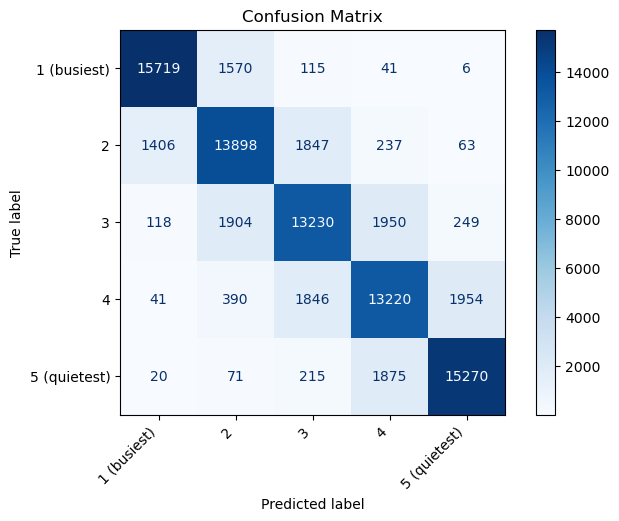


Classification Report:
              precision    recall  f1-score       support
1              0.908403  0.900751  0.904560  17451.000000
2              0.779342  0.796401  0.787779  17451.000000
3              0.766823  0.758123  0.762448  17451.000000
4              0.763147  0.757550  0.760338  17451.000000
5              0.870482  0.875021  0.872746  17451.000000
accuracy       0.817569  0.817569  0.817569      0.817569
macro avg      0.817639  0.817569  0.817574  87255.000000
weighted avg   0.817639  0.817569  0.817574  87255.000000


In [34]:
y_balanced_pred_rf = rf.predict(X_test_balanced)
evaluate_model(y_test_balanced, y_balanced_pred_rf)

### Encoded Data

In [35]:
rf.fit(X_train_encoded, y_train_encoded)

RandomForestClassifier(random_state=42)

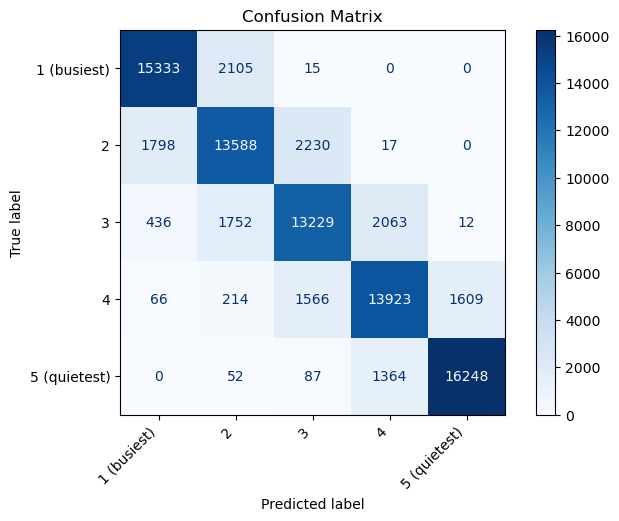


Classification Report:
              precision    recall  f1-score       support
1              0.869563  0.878531  0.874024  17453.000000
2              0.767207  0.770601  0.768900  17633.000000
3              0.772406  0.756289  0.764262  17492.000000
4              0.801693  0.801185  0.801439  17378.000000
5              0.909284  0.915329  0.912296  17751.000000
accuracy       0.824575  0.824575  0.824575      0.824575
macro avg      0.824031  0.824387  0.824184  87707.000000
weighted avg   0.824200  0.824575  0.824363  87707.000000


In [36]:
y_encoded_pred_rf = rf.predict(X_test_encoded)

evaluate_model(y_test_encoded, y_encoded_pred_rf)

### Weighted Data

In [37]:
rf.fit(X_train_weighted, y_train_weighted)

RandomForestClassifier(random_state=42)

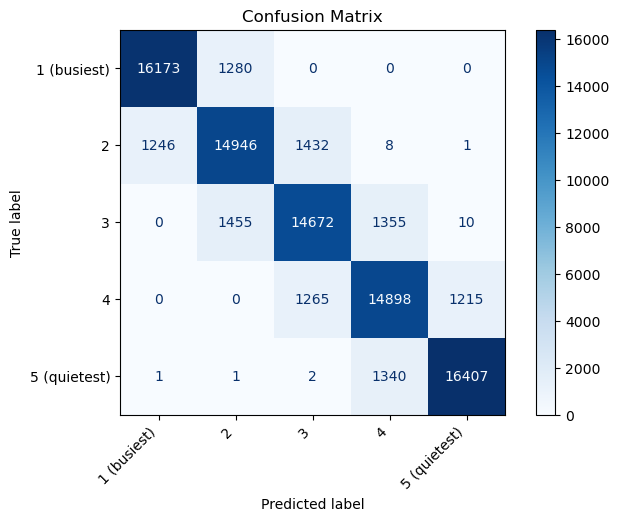


Classification Report:
              precision    recall  f1-score       support
1              0.928416  0.926660  0.927537  17453.000000
2              0.845266  0.847615  0.846439  17633.000000
3              0.844626  0.838783  0.841695  17492.000000
4              0.846429  0.857291  0.851825  17378.000000
5              0.930471  0.924286  0.927368  17751.000000
accuracy       0.879018  0.879018  0.879018      0.879018
macro avg      0.879042  0.878927  0.878973  87707.000000
weighted avg   0.879160  0.879018  0.879077  87707.000000


In [38]:
y_weighted_pred_rf = rf.predict(X_test_weighted)

evaluate_model(y_test_weighted, y_weighted_pred_rf)

**Using Original Data**

# XGBoost
### Original Data  
**Must be adjusted to represent [0, 1, 2, 3, 4]**

In [39]:
y_adjusted = y - 1
X_train_adjusted, X_test_adjusted, y_train_adjusted, y_test_adjusted = train_test_split(X, y_adjusted, test_size=0.2, random_state=42)

In [40]:
xgb = XGBClassifier(eval_metric='mlogloss', random_state=42, enable_categorical=True)
xgb.fit(X_train_adjusted, y_train_adjusted)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=True, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, objective='multi:softprob', ...)

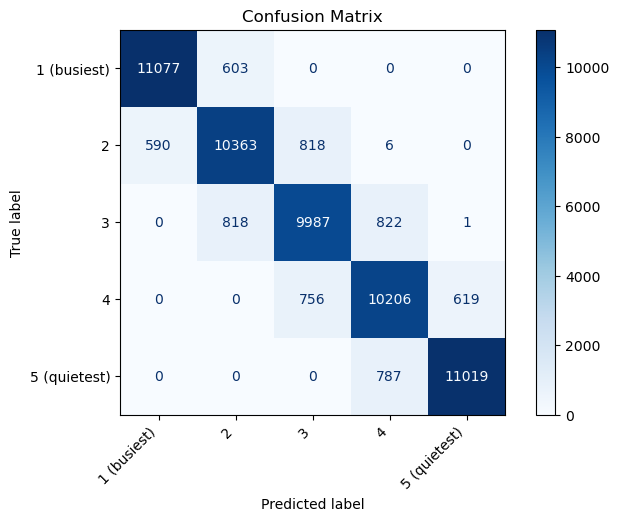


Classification Report:
              precision    recall  f1-score       support
0              0.949430  0.948373  0.948901  11680.000000
1              0.879413  0.879935  0.879674  11777.000000
2              0.863853  0.858875  0.861357  11628.000000
3              0.863379  0.881271  0.872233  11581.000000
4              0.946731  0.933339  0.939987  11806.000000
accuracy       0.900465  0.900465  0.900465      0.900465
macro avg      0.900561  0.900359  0.900430  58472.000000
weighted avg   0.900721  0.900465  0.900564  58472.000000


In [41]:
y_pred_xgb = xgb.predict(X_test_adjusted)

evaluate_model(y_test_adjusted, y_pred_xgb)

### Weighted Data

In [42]:
y_weighted_adjusted = y_weighted - 1

X_train_weighted_adjusted, X_test_weighted_adjusted, y_train_weighted_adjusted, y_test_weighted_adjusted = train_test_split(X_weighted, y_weighted_adjusted, test_size=0.3, random_state=42)

In [43]:
xgb.fit(X_train_weighted_adjusted, y_train_weighted_adjusted)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=True, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, objective='multi:softprob', ...)

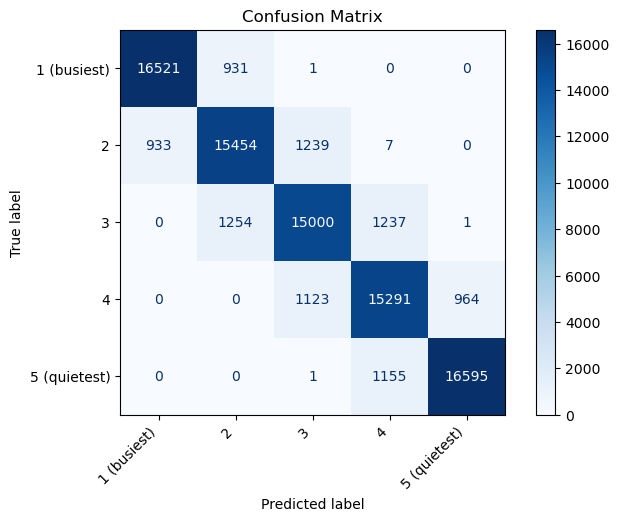


Classification Report:
              precision    recall  f1-score       support
0              0.946545  0.946599  0.946572  17453.000000
1              0.876127  0.876425  0.876276  17633.000000
2              0.863856  0.857535  0.860684  17492.000000
3              0.864387  0.879906  0.872077  17378.000000
4              0.945046  0.934877  0.939934  17751.000000
accuracy       0.899141  0.899141  0.899141      0.899141
macro avg      0.899192  0.899068  0.899109  87707.000000
weighted avg   0.899315  0.899141  0.899206  87707.000000


In [44]:
y_pred_weighted_xgb = xgb.predict(X_test_weighted_adjusted)

evaluate_model(y_test_weighted_adjusted, y_pred_weighted_xgb)

**Using Original Data**

In [45]:
xgb.fit(X_train_adjusted, y_train_adjusted)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=True, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, objective='multi:softprob', ...)

In [46]:
with open('taxi_xgb_model.pkl', 'wb') as file:
    pickle.dump(xgb, file)

# Ensemble (rf, xgboost)

**Original Data**

In [47]:
rf.fit(X_train_adjusted, y_train_adjusted)
xgb.fit(X_train_adjusted, y_train_adjusted)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=True, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, objective='multi:softprob', ...)

In [48]:
ensemble = VotingClassifier(estimators=[('rf', rf), ('xgb', xgb)], voting='soft')
ensemble.fit(X_train_adjusted, y_train_adjusted)

VotingClassifier(estimators=[('rf', RandomForestClassifier(random_state=42)),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=True,
                                            eval_metric='mlogloss',
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=None, n_jobs=None,
                                            num_parallel_tree=None,
                                            objective='multi:softprob', ...))],
                 voting='soft')

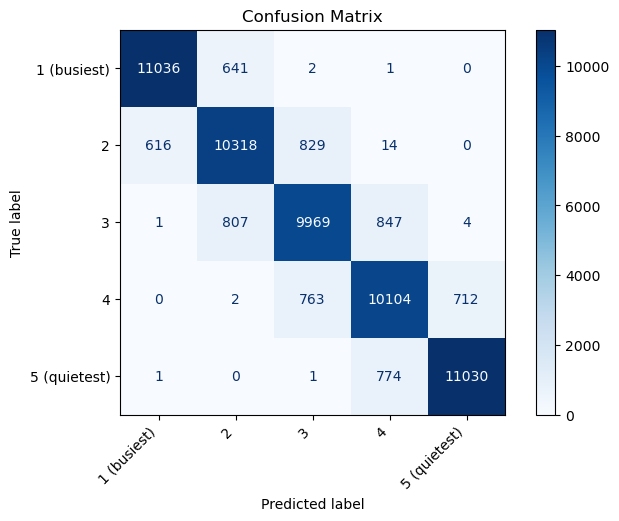


Classification Report:
              precision    recall  f1-score      support
0              0.946971  0.944863  0.945916  11680.00000
1              0.876785  0.876114  0.876449  11777.00000
2              0.862072  0.857327  0.859693  11628.00000
3              0.860647  0.872464  0.866515  11581.00000
4              0.939043  0.934271  0.936651  11806.00000
accuracy       0.897130  0.897130  0.897130      0.89713
macro avg      0.897104  0.897008  0.897045  58472.00000
weighted avg   0.897253  0.897130  0.897181  58472.00000


In [49]:
y_pred_ensemble = ensemble.predict(X_test_adjusted)
evaluate_model(y_test_adjusted, y_pred_ensemble)

### Feature Importance

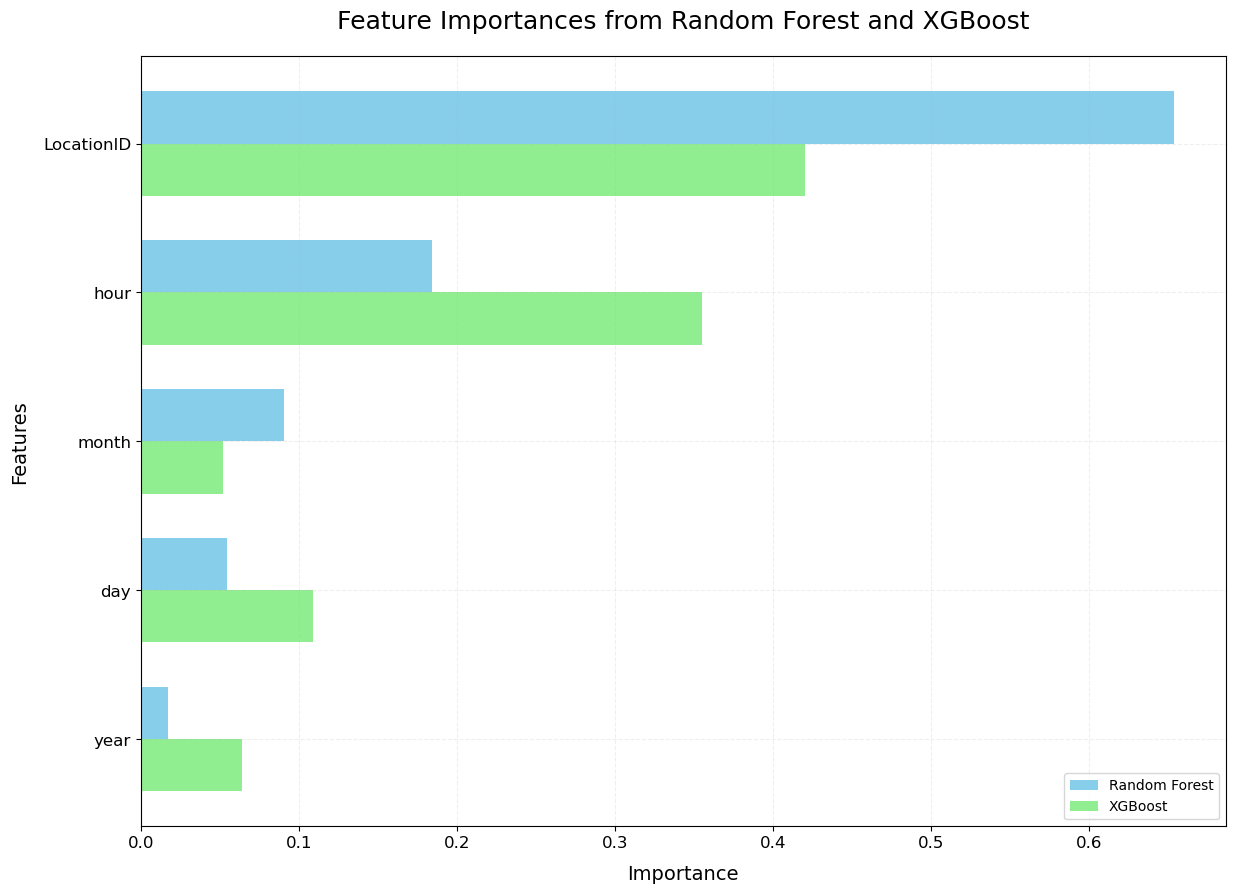

In [50]:
rf_importances = rf.feature_importances_
xgb_importances = xgb.feature_importances_

rf_importance_df = pd.DataFrame({
    'Feature': X_train_adjusted.columns,
    'RF_Importance': rf_importances
}).sort_values(by='RF_Importance', ascending=False)

xgb_importance_df = pd.DataFrame({
    'Feature': X_train_adjusted.columns,
    'XGB_Importance': xgb_importances
}).sort_values(by='XGB_Importance', ascending=False)

importance_df = pd.merge(rf_importance_df, xgb_importance_df, on='Feature')
importance_df.set_index('Feature', inplace=True)

fig, ax = plt.subplots(figsize=(14, 10))
bar_width = 0.35
index = np.arange(len(importance_df))

bar1 = ax.barh(index, importance_df['RF_Importance'], bar_width, label='Random Forest', color='skyblue')
bar2 = ax.barh(index + bar_width, importance_df['XGB_Importance'], bar_width, label='XGBoost', color='lightgreen')

ax.set_xlabel('Importance', fontsize=14, labelpad=10, color='black')
ax.set_ylabel('Features', fontsize=14, labelpad=10, color='black')
ax.set_title('Feature Importances from Random Forest and XGBoost', fontsize=18, pad=20)
ax.set_yticks(index + bar_width / 2)
ax.set_yticklabels(importance_df.index, fontsize=12)
ax.invert_yaxis()  # Highest importance at the top
ax.grid(True, linestyle='--', alpha=0.2)
ax.legend(loc="lower right", fontsize=10)

plt.xticks(fontsize=12, color='black')
plt.yticks(fontsize=12, color='black')
plt.show()

# Stacking

In [51]:
base_models = [
    ('rf', rf),
    ('xgb', xgb)
]

meta_model = LogisticRegression()

stacking = StackingClassifier(estimators=base_models, final_estimator=meta_model, cv=5)
stacking.fit(X_train_adjusted, y_train_adjusted)

StackingClassifier(cv=5,
                   estimators=[('rf', RandomForestClassifier(random_state=42)),
                               ('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=True,
                                              eval_metric='mlogloss',
                                              feature_types=None, gamma=None,
                                              grow_policy=None,
                                              im...
                                              interaction_constraints=None,
                                              learning_rate=None, max_bin=None,
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None,
                                              max_depth=None, max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=None, n_jobs=None,
                                              num_parallel_tree=None,
                                              objective='multi:softprob', ...))],
                   final_estimator=LogisticRegression())

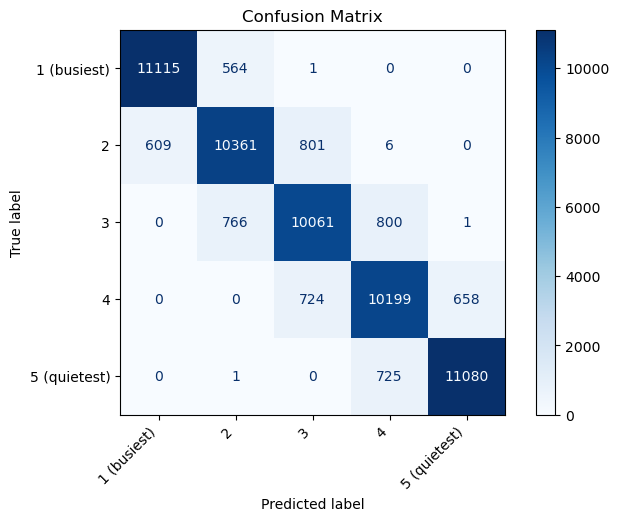


Classification Report:
              precision    recall  f1-score      support
0              0.948055  0.951627  0.949838  11680.00000
1              0.886161  0.879766  0.882952  11777.00000
2              0.868301  0.865239  0.866767  11628.00000
3              0.869480  0.880667  0.875038  11581.00000
4              0.943862  0.938506  0.941176  11806.00000
accuracy       0.903270  0.903270  0.903270      0.90327
macro avg      0.903172  0.903161  0.903154  58472.00000
weighted avg   0.903319  0.903270  0.903283  58472.00000


In [52]:
y_pred_stacking = stacking.predict(X_test_adjusted)

evaluate_model(y_test_adjusted, y_pred_stacking)

In [53]:
with open('taxi_stacking_model.pkl', 'wb') as file:
    pickle.dump(stacking, file)

In [54]:
with open('taxi_stacking_model.pkl', 'rb') as file:
    stacking_model = pickle.load(file)

In [55]:
scoring = 'accuracy'

train_sizes, train_scores, test_scores = learning_curve(
    stacking, X_train_adjusted, y_train_adjusted, cv=3, scoring=scoring, n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 5), verbose=1
)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)


[learning_curve] Training set sizes: [ 15592  50674  85757 120839 155922]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  3.3min finished


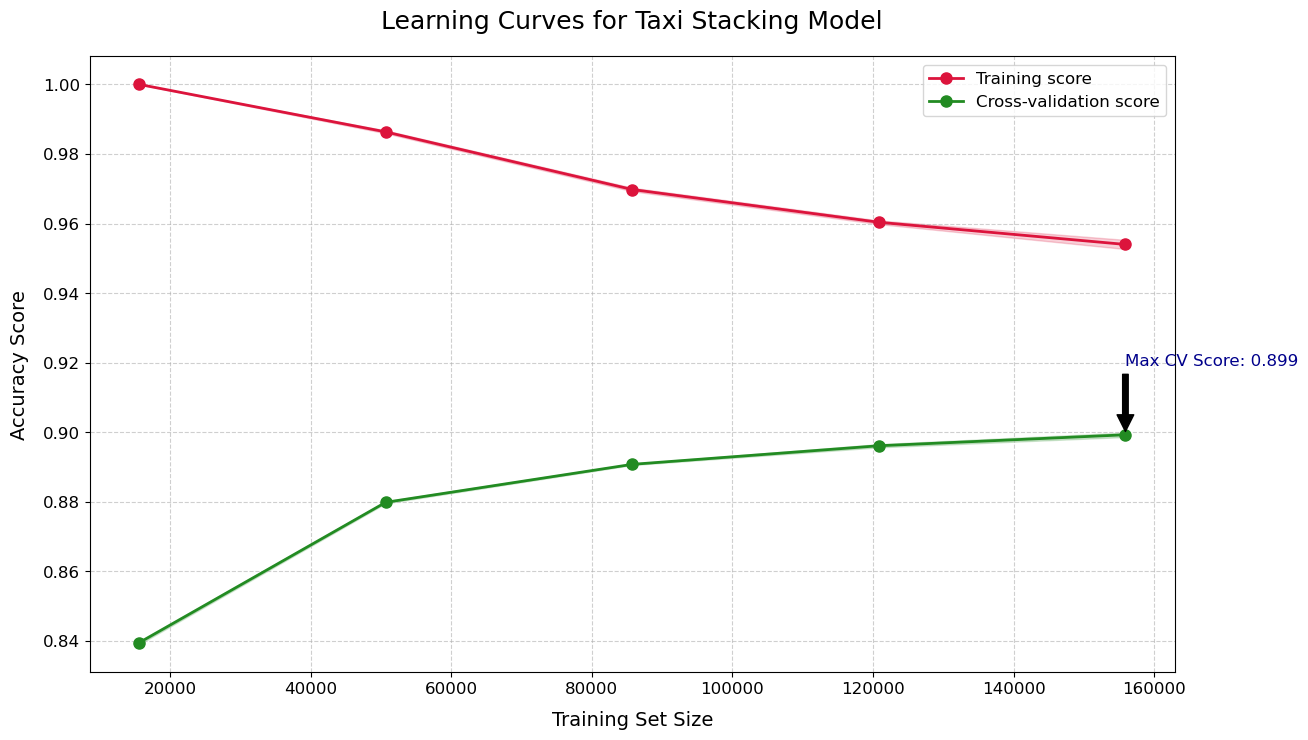

In [56]:
plt.figure(figsize=(14, 8))

plt.plot(train_sizes, train_scores_mean, 'o-', color="crimson", label="Training score", linewidth=2, markersize=8)
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.2, color="crimson")

plt.plot(train_sizes, test_scores_mean, 'o-', color="forestgreen", label="Cross-validation score", linewidth=2, markersize=8)
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.2, color="forestgreen")

max_train_size = train_sizes[np.argmax(test_scores_mean)]
max_test_score = max(test_scores_mean)
min_test_score = min(test_scores_mean)
plt.annotate(f'Max CV Score: {max_test_score:.3f}', xy=(max_train_size, max_test_score), xytext=(max_train_size, max_test_score+0.02),
             arrowprops=dict(facecolor='black', shrink=0.05), fontsize=12, color="darkblue")

plt.xlabel('Training Set Size', fontsize=14, labelpad=10)
plt.ylabel('Accuracy Score', fontsize=14, labelpad=10)
plt.title('Learning Curves for Taxi Stacking Model', fontsize=18, pad=20)
plt.legend(loc="best", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()

In [57]:
scoring = 'accuracy'

train_sizes, train_scores, test_scores = learning_curve(
    xgb, X_train_adjusted, y_train_adjusted, cv=3, scoring=scoring, n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 5), verbose=1
)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)


[learning_curve] Training set sizes: [ 15592  50674  85757 120839 155922]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:   24.7s finished


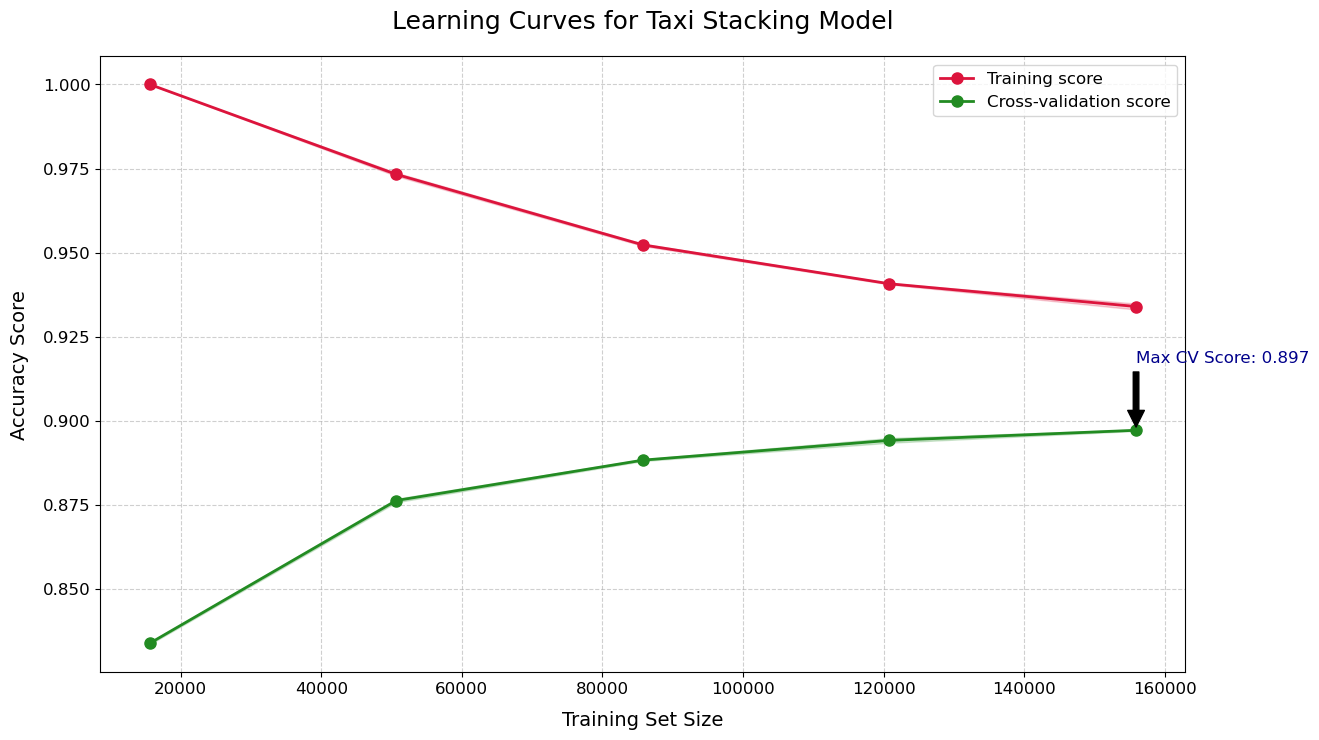

In [58]:
plt.figure(figsize=(14, 8))

plt.plot(train_sizes, train_scores_mean, 'o-', color="crimson", label="Training score", linewidth=2, markersize=8)
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.2, color="crimson")

plt.plot(train_sizes, test_scores_mean, 'o-', color="forestgreen", label="Cross-validation score", linewidth=2, markersize=8)
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.2, color="forestgreen")

max_train_size = train_sizes[np.argmax(test_scores_mean)]
max_test_score = max(test_scores_mean)
min_test_score = min(test_scores_mean)
plt.annotate(f'Max CV Score: {max_test_score:.3f}', xy=(max_train_size, max_test_score), xytext=(max_train_size, max_test_score+0.02),
             arrowprops=dict(facecolor='black', shrink=0.05), fontsize=12, color="darkblue")

plt.xlabel('Training Set Size', fontsize=14, labelpad=10)
plt.ylabel('Accuracy Score', fontsize=14, labelpad=10)
plt.title('Learning Curves for Taxi Stacking Model', fontsize=18, pad=20)
plt.legend(loc="best", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()